# llama from scratch

- Llama ia a transformer-based model for language modelling

In [149]:
# libraries 
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm

In [2]:
# get device for training

device  = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f'Using {device} device')

Using cuda device


In [59]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [60]:
device

'cuda'

## Setting up our dataset

while in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all of shakespeare's work, is about 1M characters.

In [3]:
with open('/kaggle/input/shakespeare6/shakespeare.txt', 'r') as f:
    lines = f.read()
    
vocab = sorted(list(set(lines)))
itos = {i : ch for i , ch in enumerate(vocab)}
stoi = {ch : i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [4]:
print(f"The lenght of vocabulary: {len(vocab)}")
print(vocab)

The lenght of vocabulary: 65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


They use the SentencePiece byte-pair encoding tokenizer, but we're going to just use a simple character-level tokenizer.

In [5]:
# simple tokenization by character

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


In [6]:
print(encode('hello'))
print(decode(encode('hello')))

[46, 43, 50, 50, 53]
hello


`config` object to store some basic model params.

In [7]:
MASTER_CONFIG = {
    'vocab_size' : len(vocab)
}

In [8]:
dataset = torch.tensor(encode(lines), dtype = torch.int8)
dataset.shape


torch.Size([1115394])

Creating method to generate our traning data and labels for batches.
we'll use the same method for validation and test data.

In [9]:
def get_batches(data, split, batch_size, context_window, config = MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test
        
    # pick random starting point
    ix = torch.randint(0,batch_data.size(0) - context_window- 1, (batch_size,))
    x = torch.stack([batch_data[i : i + context_window] for i in ix]).long()
    y = torch.stack([batch_data[i + 1: i + context_window + 1 ] for i in ix]).long()
    return x, y


MASTER_CONFIG.update({
    'batch_size' : 32,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]
        

    
    
        

[(' again;\nThe quee', 'again;\nThe queen'),
 ('noble wish.\n\nSIC', 'oble wish.\n\nSICI'),
 ('g nothing?\nIs le', ' nothing?\nIs lea'),
 ('o make haste,\nAn', ' make haste,\nAnd'),
 ('od lord, my frie', 'd lord, my frien'),
 ('e\nFor I have had', '\nFor I have had '),
 ('econcile them al', 'concile them all'),
 ('balt company:\nAn', 'alt company:\nAnd'),
 (' to speak big an', 'to speak big and'),
 ('es. I see\nthis i', 's. I see\nthis is'),
 ('hat shall.\nScurv', 'at shall.\nScurvy'),
 ('am thy sovereign', 'm thy sovereign.'),
 ('ad we but Claren', 'd we but Clarenc'),
 ('\n\nFirst Murderer', '\nFirst Murderer:'),
 ('s are prepared, ', ' are prepared, a'),
 ('tion alters.\n\nPE', 'ion alters.\n\nPER'),
 (' wife, triumph n', 'wife, triumph no'),
 ('easant, speedy,\n', 'asant, speedy,\nT'),
 ("ith swallow's wi", "th swallow's win"),
 ('ght forth her pr', 'ht forth her pro'),
 ('er head on one s', 'r head on one si'),
 ('e long before\nI ', ' long before\nI c'),
 (' bestow\nYour sue', 'b

method for evaluation of model.

In [73]:
@torch.no_grad() # don't compute gradients for this function
def evaluate_loss(model, config = MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'])
            xb , yb = xb.to(device), yb.to(device)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

A basic feed-forward neural network with embeddings. It's a base model we're going to start with, and then swap out parts of it as go along until we eventually end up with the base model as described in Llama.

In [68]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config = MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        print("model params: ",sum([m.numel() for m in self.parameters()]))
        
    def forward(self,idx, targets = None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim = -1)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
        
MASTER_CONFIG.update(
    {'d_model': 128,}
)

model = SimpleBrokenModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)
logits, loss = model(xs, ys)

model params:  33217


In [62]:
model

SimpleBrokenModel(
  (embedding): Embedding(65, 128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=65, bias=True)
  )
)

let's train our SimpleBrokenModel to make sure the gradients flow.

model params:  35265


100%|██████████| 1000/1000 [00:05<00:00, 171.82it/s]

validation loss:  2.4801454544067383


<Axes: >

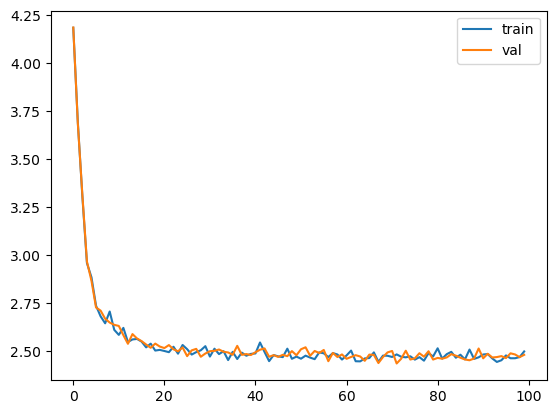

In [150]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10
})

model = SimpleBrokenModel(MASTER_CONFIG).to(device)

optimizer = torch.optim.Adam(
    model.parameters()
)



def train(model, optimizer, scheduler = None,config = MASTER_CONFIG,print_logs = False):
    losses = []
    start_time = time.time()
    for epoch in tqdm(range(config['epochs'])):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
        xs, ys = xs.to(device), ys.to(device)
        logits, loss = model(xs, targets = ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
            
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)

            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss{x['val']:.3f} | Time {batch_time} | ETA in seconds {batch_time * (config['epochs'] - epoch)/ config['log_interval'] :.3f}")
                
            start_time = time.time()
            if scheduler:
                print("lr: ", scheduler.get_lr())
                
    print('validation loss: ', losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Notice how we get a training curve that goes down, but barely by anything. How do we know it's barely training? We have to use first principles. The cross-entropy loss before training is 4.17, and after 1000 epochs is 3.93. How can we make sense of it intuitively?

Cross-entropy in this context is referring to how likely we are to pick the wrong word. So here,

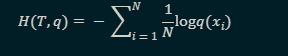

where $q(x_i)$ is the probability of picking the right word, as estimated by the model. If $q(x_i)$ is close to 1, then $\log q$ is close to 0; similarly, if $q$ is small, then $\log q$ is a large negative number, so $-\log q$ will be a large positive number. Now to build the intuition: to start, $-\log q = 4.17$, so $q = 0.015$, or around $\frac{1}{64.715}$. Recall that the vocabulary size $|V| = 65$, so what we're basically saying here is that the model is as good at choosing the next letter as randomly picking from our vocabulary. After training, $-\log q = 3.93$, so we're now basically choosing between 50 letters. This is a very small improvement, so something is probably wrong.

To get an intuition for how the loss relates to the model's performance, think about the model choosing among $\tilde V$ tokens; when $\tilde V$ is small, the model is more likely to guess right. In addition, we know $\max \tilde V = V$, which can help us understand if our model is learning at all.

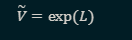

Let's try to debug what's going on. Notice that in our model we're using a softmax layer on our logits, which is a function that takes a vector of numbers and squashes them into a probability distribution. But for using the built in F.cross_entropy function, we need to pass in the unnormalized logits directly. So let's remove that from our model and try again.

model params:  33217


100%|██████████| 1000/1000 [00:05<00:00, 192.98it/s]


validation loss:  2.4844679832458496


<Axes: >

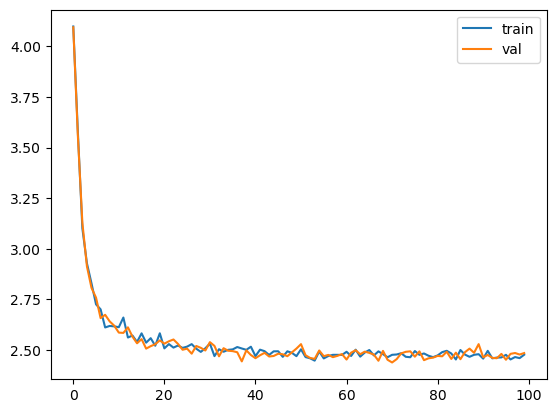

In [151]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config = MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        
        print("model params: ",sum([m.numel() for m in self.parameters()]))
        
    def forward(self,idx, targets = None):
        x = self.embedding(idx)
        logits = self.linear(x)
        
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
        
MASTER_CONFIG.update(
    {'d_model': 128,}
)

model = SimpleBrokenModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)
logits, loss = model(xs, ys)

optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great, now our loss is $2.54$ ,so we're choosing from $12.67$ characters. That's way better than the 65 we started with . Let's add a generate method to our model so we visually see the result of our model.

In [152]:
def generate(model, config = MASTER_CONFIG, max_new_token = 30):
    idx = torch.zeros(5,1).long()
    idx = idx.to(device)
    for _ in range(max_new_token):
        # call the model
        logits = model(idx[:, - config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ] # all the batches (1), last_time_step, all the logits
        p = F.softmax(last_time_step_logits, -1) # softmax to get probablities
        idx_next = torch.multinomial(
            p, num_samples = 1
        ) # sample from the distribution to get the new token
        idx = torch.cat([idx, idx_next], dim = -1) # addpend to sequence
        
    return [decode(x) for x in idx.tolist()]

generate(model)
        
    

['\n\nBOru t coweat; Y:\nThingrndr w',
 '\nWAPr se.\nPARIUSue tof hoink tu',
 '\nThichencethikidsave O boarong ',
 '\n\nARThale fl bon towe t ts plth',
 '\nInghens heavear, he ur:\nNo ING']

It's not half bad, but also not half good. But now we have a working model that is training to a validation loss. So here we'll iterate on our model to make it closer to Llama.

## Llama specifies
Llama describe three architectural modifications to the original Transformer:

1. RMSNorm for pre-normalization
2. Rotary embeddings
3. SwiGLU activation function

We're going to add each one, one at a time to our base model, and interate.

## RMSNorm
In Vaswani 2017, the original transformer uses BatchNormalization. In Llama, the authors use RMSNorm, which is where you scale the vector by the variance without centering it. In addition, while Vaswani applies normalization to the output of the attention layer (post-normalization), Llama applies it to the inputs before (pre-normalization).

In [153]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps = 1e-8, bias = False):
        super(RMSNorm, self).__init__()
        self.register_parameter('scale', nn.Parameter(torch.ones(layer_shape)))
        
    def forward(self,x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1 / sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw
    
    
config = {
    'batch_size' : 5,
    'context_window': 11,
    'd_model': 13,
}    
  
batch = torch.randn((config['batch_size'],config['context_window'],
                    config['d_model'])).to(device)

m = RMSNorm((config['context_window'], config['d_model'])).to(device)
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


We want to test to ensure that the RMSNorm is doing what we think it should. We can do this the old-fashioned way: row-wise comparisions. The RMSNorm has the property where the norm of the layer will be the square root of the number of elements in the layer, so we can check that for every layer.

In [154]:
rms = torch.linalg.norm(batch, dim = (1,2)) * (batch[0].numel() ** -0.5)

# scaled_batch.var(dim= (1,2))

assert torch.linalg.norm(torch.arange(5).float()) == (torch.arange(5).float() ** 2).sum() ** 0.5
rms = torch.linalg.norm(torch.arange(5).float()) * (torch.arange(5).numel() ** -0.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** 0.5))
ff_rms = torch.linalg.norm(batch, dim = (1,2)) * batch.shape[1:].numel() ** -0.5

#RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
    
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

Alright, so that's RMSNorm, and it seems like it's working. Again, let's test it out.

model params:  35265


100%|██████████| 1000/1000 [00:05<00:00, 175.34it/s]


validation loss:  2.4568884134292603


<Axes: >

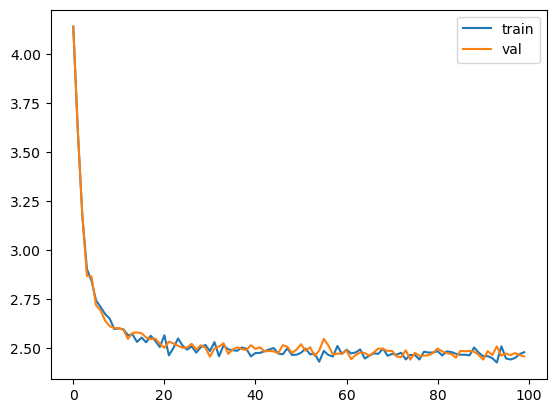

In [155]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config = MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'],config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        
        print("model params: ",sum([m.numel() for m in self.parameters()]))
        
    def forward(self,idx, targets = None):
        x = self.embedding(idx)
        x = self.rms(x)
        logits = self.linear(x)
        
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        


model = SimpleBrokenModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)
logits, loss = model(xs, ys)


optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

So RMSNorm works, and it got our loss down by a small amount.

## Rotary Embeddings

<a href = https://arxiv.org/pdf/2104.09864.pdf>RoPE</a> is a kind of positional encoding for transformers. In Attention is All You Need, the authors propose two kinds of positional encodings, learned and fixed. In RoPE, the authors propose embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

In [114]:

def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False).to(device)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

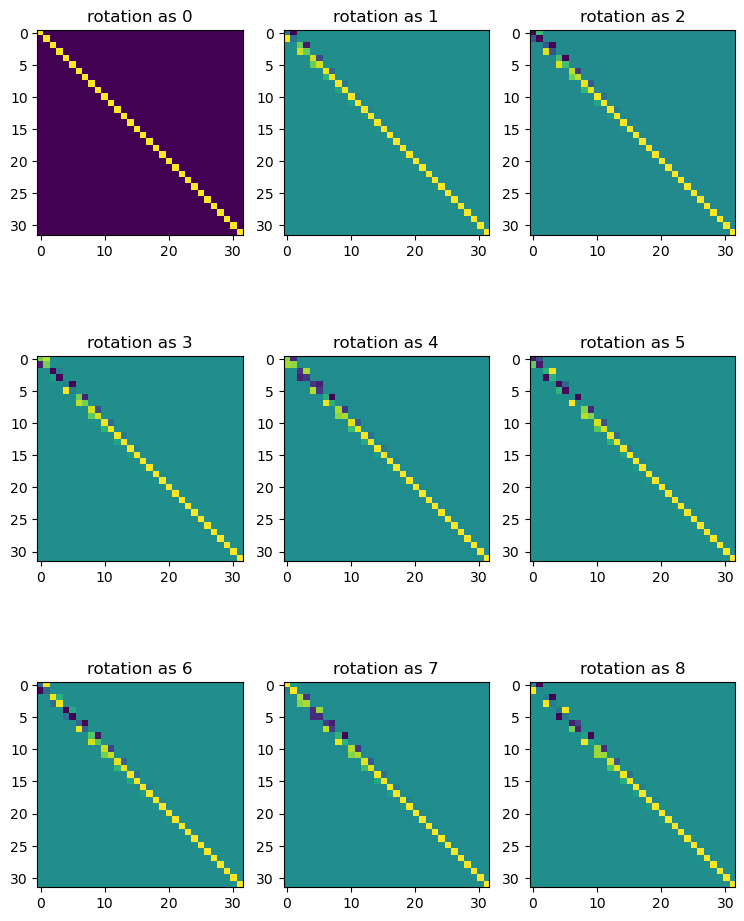

In [117]:
k = 3
config = {
    'batch_size' : 10,
    'd_model' : 32,
    "n_heads" : 8,
    'context_window' : k ** 2
}

batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(k, k, figsize = (k * 3, k * 4))
for i in range(k):
    for j in range(k):
        ax[i,j].imshow(R[i * k + j, :, :].detach().cpu().numpy())
        ax[i,j].set_title(f"rotation as {i * k + j}")

Let's make sure these work. They should exhibit that quality.

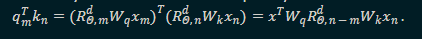

In [118]:
config = {
    'd_model' : 128,
    'context_window' : 16,
}

R = get_rotary_matrix(config['context_window'],config['d_model']).to(device)
x = torch.randn(config['d_model']).to(device)
y = torch.randn(config['d_model']).to(device)

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n , x @ R[n - m, :, :] @ y)


So the RoPE rotation work as expected.

In [156]:
config = {
    'batch_size' : 10,
    'd_model' : 512,
    'n_heads' : 8,
    'context_window' : 16
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias = False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias = False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias = False)
        
        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout = 0.1, batch_first = True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])
        
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad = False).to(device)
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self,x, return_attn_weights = False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R)).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R)).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R)).transpose(0,1)

        activations, attn_weigths = self.multihead(
            q_out, k_out, v_out
        )
        
        if return_attn_weights:
            return activations, attn_weigths
        return activations
    
layer = RoPEAttention(config).to(device)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model'])).to(device)
output , attn_weights = layer(batch, return_attn_weights = True)

Although at train time, you can expect your tensor dimensions to match your model parameters closely, eg `batch.shape = (config['batch_size'], config['context_window'], config['d_model'])`, at inference time, you may have to deal with a single example, eg `batch.shape = (1, 1, config['d_model'])`. For this reason, you need to make sure that when you're indexing in the `forward` pass, you're indexing using shapes derived from the input, not necessarily the model parameters.

Let's make sure it does what we think it does. For this layer, we're going to want to test three things:

1. that it rotates embeddings the way we think it does
2. that the attention mask used for causal attention is working properly.

In [157]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model'])).to(device)


q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])
    
    
q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)


assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [158]:
config = {
    'batch_size' : 1,
    'd_model': 2,
    "n_heads": 2,
    "context_window" : 3,
}

layer = RoPEAttention(config).to(device)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model'])).to(device)
output, attn_weights = layer(batch, return_attn_weights = True)

m = 0
x_q = batch[0,m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m,:,:] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0,n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n,:,:] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose in redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

Now let's inspect the attention weights. Since this is causal, we would expect that due to masking, the upper triangular of the attention should be 0.

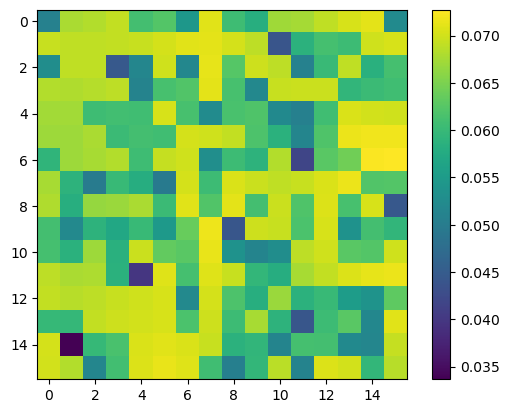

In [159]:
MASTER_CONFIG.update({
    'n_heads': 8
})

layer = RoPEAttention(MASTER_CONFIG).to(device)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])).to(device)
output, attn_weights = layer(batch, return_attn_weights = True)

plt.imshow(attn_weights[0].detach().cpu().numpy(), interpolation = 'nearest')
plt.colorbar()

This is not good; it means that information is leaking across the attention . We need to ensure the casual mask in working.

In [160]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R[:m, ...])).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out, 
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m).to(device), 
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

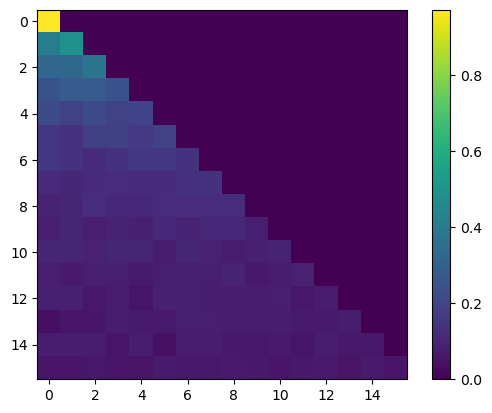

In [161]:
layer = RoPEAttention_wMask(MASTER_CONFIG).to(device)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])).to(device)
output, attn_weights = layer(batch, return_attn_weights = True)

plt.imshow(attn_weights[0].detach().cpu().numpy(), interpolation = 'nearest')
plt.colorbar()

Let's run it and see what happens.

model params:  150465


100%|██████████| 1000/1000 [00:09<00:00, 103.68it/s]

validation loss:  2.056195545196533


<Axes: >

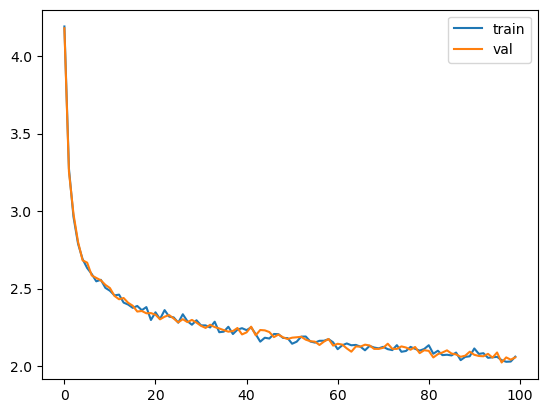

In [162]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)
        
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )
        
        self.last_linear = nn.Linear(config['d_model'],config['vocab_size'])
        print("model params: ", sum([m.numel() for m in self.parameters()]))
        
    def forward(self, idx, targets = None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)
        
        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)
        
        logits = self.last_linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        
        
model = RopeModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

It looks like we can drive our loss down even lower. Let's do that by updating master config.

100%|██████████| 5000/5000 [00:49<00:00, 101.33it/s]

validation loss:  1.8032915234565734


<Axes: >

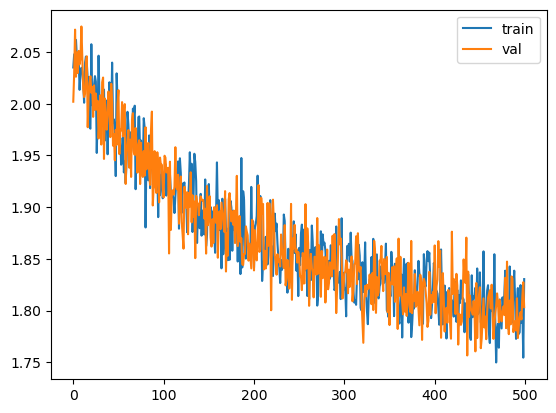

In [163]:
MASTER_CONFIG.update({
    'epochs' : 5000,
    'log_interval':  10,
})

train(model, optimizer)

## SwiGLU
As it says in the paper, "We replace the ReLU non-linearity by the SwiGLU activation function...we use a dimension of $\frac{2}{3} 4d$ isntead of $4d$ as in PaLM." SwiGLU is defined as:

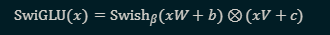

where $\otimes$ is a component-wise product. The Swish function is defined as:

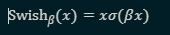

where $\beta$ is a learnable parameter.

In [34]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    
    def __init__(self,size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad = True)
        
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter('beta', self.beta)
        
    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params:  183490


100%|██████████| 5000/5000 [00:53<00:00, 92.85it/s]


validation loss:  1.7372566342353821


<Axes: >

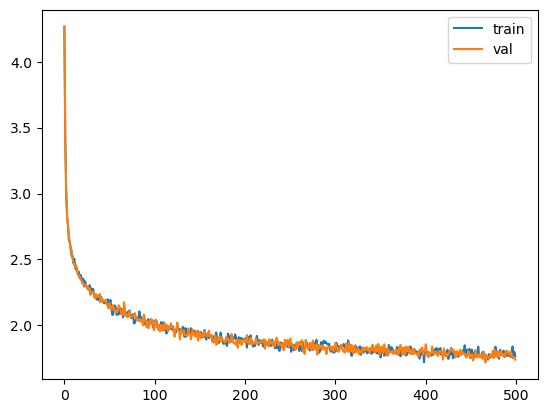

In [164]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)
        
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        
        self.last_linear = nn.Linear(config['d_model'],config['vocab_size'])
        print("model params: ", sum([m.numel() for m in self.parameters()]))
        
    def forward(self, idx, targets = None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)
        
        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)
        
        logits = self.last_linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        
        
model = RopeModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Now, let's add multiple layers of RopeAttention by creating blocks.

In [165]:
# add RMSNorm and residual connection

class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model'])
        )
        
    def forward(self,x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)
        
        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [166]:
block = LlamaBlock(MASTER_CONFIG).to(device)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'],MASTER_CONFIG['d_model']).to(device));


model params: 733382


100%|██████████| 5000/5000 [02:27<00:00, 33.85it/s]


validation loss:  1.4496744394302368


<Axes: >

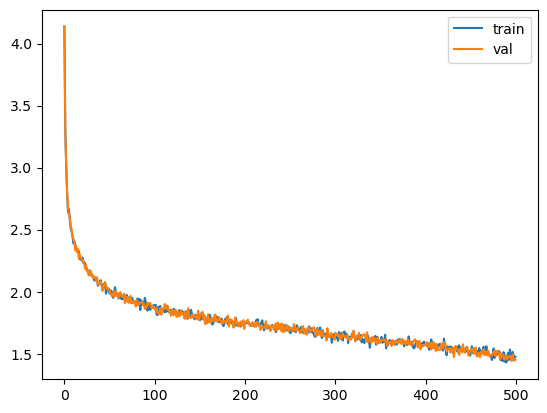

In [167]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4
})

class Llama(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embeddings  = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        ) 
        
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        
        print("model params:", sum([m.numel() for m in self.parameters()]))
        
    def forward(self, idx, targets = None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)
        
        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
llama = Llama(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config = MASTER_CONFIG)

It looks like we can drive the loss down even more, and although we're overfitting a little, I think we can still do better. Let's train longer.

100%|██████████| 10000/10000 [04:57<00:00, 33.65it/s]

validation loss:  0.7668211877346038


<Axes: >

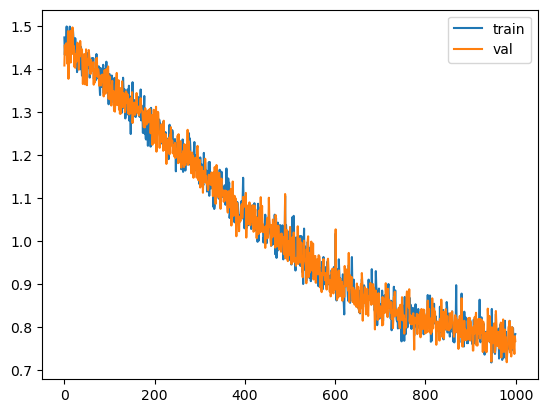

In [168]:
MASTER_CONFIG.update({
    "epochs" : 10000
})

train(llama, optimizer, scheduler = None, config = MASTER_CONFIG) 


It seems we can go even lower, still without serious overfitting. Either there is a leak, or it's actually doing well. The loss here is 1.08, which is equivalent to choosing between 2.9 tokens randomly.

100%|██████████| 10000/10000 [04:57<00:00, 33.57it/s]

validation loss:  0.6760592222213745


<Axes: >

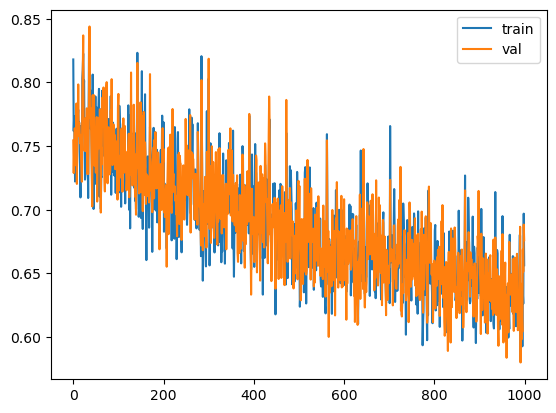

In [170]:
train(llama, optimizer, config = MASTER_CONFIG)

In [171]:
print(generate(llama, MASTER_CONFIG, 500)[0])



TwDT the tetle drevosite.

QUEENWS:
I carm I remy ajocilebation'd
Tell cape ourself,
Your oftiend,
Or.

I love the the thems: fie, yeks be teataune, o' inced blowice,--poor, Vorsmition hith they drumi grancey;
Year be your usighting
To borth'd good of yether
vilsed, Cnmot,
Seed,
And butchose this arralon disage, they, but
Anowh Your putty be that daugh threcest
And made mech of fourt towicked sir.

BANCESTER:
Q o wear,
I ray are then,
Herk like a minuely, this your cope would actarx,
I cruse as 


At this point, we've hit the bottom with our traning. Let's test on the test set.

In [172]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)

logits, loss = llama(xs, ys)
print(loss)

tensor(0.8792, device='cuda:0', grad_fn=<NllLossBackward0>)


## check for Gradient Flows

Let's inspect the gradient, we want to see how they're flowing. If there are too many gradients where the value is close to 0 , that's a problem.

In [174]:
def show_grads(model, tol = 1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param)<= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key = lambda t : t[1],reverse = True)
show_grads(llama)

[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 35.9375),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 35.15625),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 34.375),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 34.114583333333336),
 ('llama_blocks.llama_0.attention.multihead.in_proj_weight', 21.8505859375),
 ('llama_blocks.llama_0.attention.w_q.weight', 14.825439453125),
 ('llama_blocks.llama_0.attention.w_k.weight', 12.713623046875),
 ('llama_blocks.llama_0.attention.w_v.weight', 12.591552734375),
 ('llama_blocks.llama_0.attention.multihead.out_proj.weight', 12.017822265625),
 ('llama_blocks.llama_2.attention.multihead.out_proj.bias', 11.71875),
 ('llama_blocks.llama_2.attention.multihead.out_proj.weight', 11.480712890625),
 ('llama_blocks.llama_1.attention.w_v.weight', 11.34033203125),
 ('llama_blocks.llama_2.attention.w_v.weight', 10.699462890625),
 ('llama_blocks.llama_3.attention.multihead.out_proj.weight', 10.687255859375),
 

Here, for all of our parameter gradients, the vast majority are non-zero, which is great. If we start to see this number peak higher, then our gradients would not be flowing.

## Experiment with hyperparams, aka "change the oven settings"
In the original Llama paper, the authors use Cosine Annealing learning schedule. We didn't do that here, because I experimented and saw that it was worse.

model params: 733382


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 1/1000 [00:00<02:20,  7.13it/s]

lr:  [0.0009999457184159408]


  2%|▏         | 19/1000 [00:00<00:24, 40.17it/s]

lr:  [0.0009961510274583004]


  2%|▏         | 24/1000 [00:00<00:29, 33.64it/s]

lr:  [0.0009869757772816292]


  4%|▍         | 38/1000 [00:01<00:24, 39.52it/s]

lr:  [0.0009725204933511963]


  5%|▌         | 50/1000 [00:01<00:23, 41.29it/s]

lr:  [0.0009529435502760634]


  6%|▌         | 55/1000 [00:01<00:26, 35.44it/s]

lr:  [0.0009284594366176498]


  7%|▋         | 68/1000 [00:01<00:23, 39.32it/s]

lr:  [0.0008993364049014041]


  8%|▊         | 80/1000 [00:02<00:22, 41.04it/s]

lr:  [0.0008658935325782156]


  8%|▊         | 85/1000 [00:02<00:26, 34.99it/s]

lr:  [0.0008284972261358946]


 10%|▉         | 98/1000 [00:02<00:22, 39.46it/s]

lr:  [0.0007875572066618724]


 11%|█         | 110/1000 [00:03<00:21, 41.16it/s]

lr:  [0.0007435220208394261]


 12%|█▏        | 115/1000 [00:03<00:24, 35.64it/s]

lr:  [0.0006968741265588948]


 13%|█▎        | 128/1000 [00:03<00:21, 39.90it/s]

lr:  [0.0006481246069855613]


 14%|█▍        | 140/1000 [00:03<00:20, 41.24it/s]

lr:  [0.0005978075709959357]


 15%|█▌        | 150/1000 [00:04<00:23, 36.11it/s]

lr:  [0.0005464743013294258]


 15%|█▌        | 154/1000 [00:04<00:26, 31.41it/s]

lr:  [0.0004946872145648923]


 17%|█▋        | 167/1000 [00:04<00:23, 35.60it/s]

lr:  [0.00044301369909075325]


 18%|█▊        | 178/1000 [00:05<00:22, 36.99it/s]

lr:  [0.00039201989856974814]


 19%|█▉        | 190/1000 [00:05<00:20, 39.24it/s]

lr:  [0.0003422645089892466]


 20%|█▉        | 195/1000 [00:05<00:23, 33.76it/s]

lr:  [0.0002942926572257539]


 21%|██        | 208/1000 [00:05<00:20, 38.39it/s]

lr:  [0.0002486299281339155]


 22%|██▏       | 220/1000 [00:06<00:19, 40.61it/s]

lr:  [0.0002057766054928797]


 22%|██▎       | 225/1000 [00:06<00:21, 35.38it/s]

lr:  [0.00016620218969383484]


 24%|██▍       | 238/1000 [00:06<00:19, 39.28it/s]

lr:  [0.00013034025177986015]


 25%|██▌       | 250/1000 [00:06<00:18, 40.60it/s]

lr:  [9.85836791664324e-05]


 26%|██▌       | 255/1000 [00:07<00:21, 35.16it/s]

lr:  [7.128036241775617e-05]


 27%|██▋       | 268/1000 [00:07<00:18, 39.02it/s]

lr:  [4.872936226262451e-05]


 28%|██▊       | 280/1000 [00:07<00:17, 40.26it/s]

lr:  [3.117756953567661e-05]


 28%|██▊       | 285/1000 [00:08<00:20, 35.04it/s]

lr:  [1.8816750064937722e-05]


 30%|██▉       | 298/1000 [00:08<00:17, 39.24it/s]

lr:  [1.1779739336260682e-05]


 31%|███       | 310/1000 [00:08<00:16, 41.02it/s]

lr:  [1.0054282328142978e-05]


 32%|███▏      | 315/1000 [00:08<00:19, 35.02it/s]

lr:  [1.396862020283371e-05]


 33%|███▎      | 328/1000 [00:09<00:17, 38.99it/s]

lr:  [2.3138198807489664e-05]


 34%|███▍      | 340/1000 [00:09<00:16, 40.93it/s]

lr:  [3.7591595433673565e-05]


 34%|███▍      | 345/1000 [00:09<00:18, 35.32it/s]

lr:  [5.716757986058714e-05]


 36%|███▌      | 358/1000 [00:09<00:16, 39.01it/s]

lr:  [8.165110310035915e-05]


 37%|███▋      | 370/1000 [00:10<00:15, 40.71it/s]

lr:  [0.00011077372717831143]


 38%|███▊      | 375/1000 [00:10<00:17, 35.12it/s]

lr:  [0.00014421629539013414]


 39%|███▉      | 388/1000 [00:10<00:15, 38.77it/s]

lr:  [0.00018161236159547207]


 40%|████      | 400/1000 [00:11<00:14, 40.34it/s]

lr:  [0.00022255218257041356]


 40%|████      | 405/1000 [00:11<00:17, 34.94it/s]

lr:  [0.000266587198202317]


 42%|████▏     | 418/1000 [00:11<00:14, 39.19it/s]

lr:  [0.0003132349418762423]


 43%|████▎     | 430/1000 [00:11<00:14, 40.41it/s]

lr:  [0.00036198432439864383]


 44%|████▎     | 435/1000 [00:12<00:16, 34.92it/s]

lr:  [0.0004123012324667328]


 45%|████▍     | 448/1000 [00:12<00:14, 38.97it/s]

lr:  [0.0004636343798727908]


 46%|████▌     | 460/1000 [00:12<00:13, 40.47it/s]

lr:  [0.0005154213471150505]


 46%|████▋     | 465/1000 [00:13<00:15, 34.59it/s]

lr:  [0.0005670947431326734]


 48%|████▊     | 478/1000 [00:13<00:13, 38.75it/s]

lr:  [0.0006180884215964124]


 49%|████▉     | 490/1000 [00:13<00:12, 40.58it/s]

lr:  [0.0006678436836148735]


 50%|████▉     | 495/1000 [00:13<00:14, 34.82it/s]

lr:  [0.0007158153988789835]


 50%|█████     | 505/1000 [00:14<00:15, 32.00it/s]

lr:  [0.0007614779781684484]


 52%|█████▏    | 518/1000 [00:14<00:12, 37.27it/s]

lr:  [0.000804331131776918]


 53%|█████▎    | 530/1000 [00:14<00:11, 39.78it/s]

lr:  [0.0008439053507606745]


 54%|█████▎    | 535/1000 [00:15<00:13, 34.29it/s]

lr:  [0.0008797670509540543]


 55%|█████▍    | 548/1000 [00:15<00:11, 38.84it/s]

lr:  [0.000911523323390634]


 56%|█████▌    | 560/1000 [00:15<00:10, 40.77it/s]

lr:  [0.0009388262390821264]


 56%|█████▋    | 565/1000 [00:15<00:12, 34.93it/s]

lr:  [0.0009613766609899277]


 58%|█████▊    | 578/1000 [00:16<00:10, 38.90it/s]

lr:  [0.000978927521423828]


 59%|█████▉    | 590/1000 [00:16<00:10, 40.41it/s]

lr:  [0.0009912865289594924]


 60%|█████▉    | 595/1000 [00:16<00:11, 34.10it/s]

lr:  [0.0009983182752167246]


 61%|██████    | 608/1000 [00:17<00:10, 37.94it/s]

lr:  [0.0009999457184159232]


 62%|██████▏   | 620/1000 [00:17<00:09, 39.54it/s]

lr:  [0.000996151027458283]


 62%|██████▎   | 625/1000 [00:17<00:13, 28.25it/s]

lr:  [0.0009869757772816123]


 64%|██████▍   | 639/1000 [00:18<00:12, 28.56it/s]

lr:  [0.0009725204933511797]


 65%|██████▍   | 648/1000 [00:18<00:12, 27.83it/s]

lr:  [0.0009529435502760468]


 66%|██████▌   | 659/1000 [00:18<00:10, 31.29it/s]

lr:  [0.0009284594366176342]


 67%|██████▋   | 670/1000 [00:19<00:09, 36.00it/s]

lr:  [0.0008993364049013886]


 68%|██████▊   | 675/1000 [00:19<00:10, 32.19it/s]

lr:  [0.0008658935325782018]


 69%|██████▉   | 688/1000 [00:19<00:08, 38.00it/s]

lr:  [0.0008284972261358809]


 70%|███████   | 700/1000 [00:20<00:07, 40.26it/s]

lr:  [0.0007875572066618594]


 70%|███████   | 705/1000 [00:20<00:08, 34.96it/s]

lr:  [0.0007435220208394129]


 72%|███████▏  | 718/1000 [00:20<00:07, 39.24it/s]

lr:  [0.0006968741265588833]


 73%|███████▎  | 730/1000 [00:20<00:06, 40.78it/s]

lr:  [0.000648124606985551]


 74%|███████▎  | 735/1000 [00:21<00:07, 35.18it/s]

lr:  [0.0005978075709959263]


 75%|███████▍  | 748/1000 [00:21<00:06, 39.29it/s]

lr:  [0.0005464743013294161]


 76%|███████▌  | 760/1000 [00:21<00:05, 41.23it/s]

lr:  [0.000494687214564885]


 76%|███████▋  | 765/1000 [00:21<00:06, 35.73it/s]

lr:  [0.00044301369909074663]


 78%|███████▊  | 778/1000 [00:22<00:05, 39.60it/s]

lr:  [0.00039201989856974207]


 79%|███████▉  | 790/1000 [00:22<00:05, 40.95it/s]

lr:  [0.00034226450898924046]


 80%|███████▉  | 795/1000 [00:22<00:05, 35.29it/s]

lr:  [0.0002942926572257497]


 81%|████████  | 808/1000 [00:22<00:04, 39.25it/s]

lr:  [0.00024862992813391206]


 82%|████████▏ | 820/1000 [00:23<00:04, 40.51it/s]

lr:  [0.00020577660549287615]


 82%|████████▎ | 825/1000 [00:23<00:04, 35.21it/s]

lr:  [0.00016620218969383215]


 84%|████████▍ | 838/1000 [00:23<00:04, 39.51it/s]

lr:  [0.0001303402517798579]


 85%|████████▍ | 848/1000 [00:24<00:04, 35.32it/s]

lr:  [9.858367916643169e-05]


 86%|████████▌ | 859/1000 [00:24<00:03, 37.73it/s]

lr:  [7.128036241775535e-05]


 86%|████████▋ | 864/1000 [00:24<00:04, 33.10it/s]

lr:  [4.872936226262426e-05]


 88%|████████▊ | 878/1000 [00:24<00:03, 38.80it/s]

lr:  [3.1177569535676456e-05]


 89%|████████▉ | 890/1000 [00:25<00:02, 40.62it/s]

lr:  [1.8816750064937638e-05]


 90%|████████▉ | 895/1000 [00:25<00:02, 35.11it/s]

lr:  [1.1779739336260655e-05]


 91%|█████████ | 908/1000 [00:25<00:02, 39.30it/s]

lr:  [1.0054282328142978e-05]


 92%|█████████▏| 920/1000 [00:26<00:01, 40.72it/s]

lr:  [1.396862020283372e-05]


 92%|█████████▎| 925/1000 [00:26<00:02, 34.99it/s]

lr:  [2.3138198807489698e-05]


 94%|█████████▍| 938/1000 [00:26<00:01, 39.33it/s]

lr:  [3.759159543367397e-05]


 95%|█████████▌| 950/1000 [00:26<00:01, 40.41it/s]

lr:  [5.716757986058744e-05]


 96%|█████████▌| 955/1000 [00:27<00:01, 35.24it/s]

lr:  [8.165110310035937e-05]


 97%|█████████▋| 968/1000 [00:27<00:00, 39.51it/s]

lr:  [0.00011077372717831273]


 98%|█████████▊| 980/1000 [00:27<00:00, 41.09it/s]

lr:  [0.00014421629539013508]


 98%|█████████▊| 985/1000 [00:27<00:00, 35.29it/s]

lr:  [0.0001816123615954726]


100%|██████████| 1000/1000 [00:28<00:00, 35.31it/s]

lr:  [0.00022255218257041378]
validation loss:  4.1723836898803714


<Axes: >

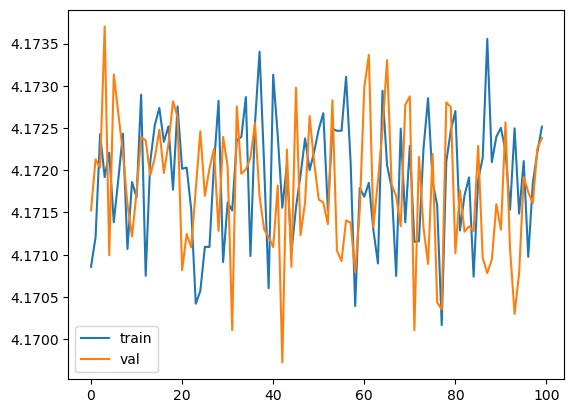

In [177]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG).to(device)
llama_optimizer = torch.optim.Adam(
    llama.parameters(), 
    betas=(.9, .95), 
    weight_decay=.1, 
    eps=1e-9, 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [178]:
show_grads(llama_with_cosine, 1e-5)

[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_0.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_0.feedforward.0.weight', 0.0244140625),
 ('llama_blocks.llama_1.attention.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_1.attention.multihead.out_proj.weight', 0.0244140625),
 ('llama_blocks.llama_0.attention.w_q.weight', 0.018310546875),
 ('llama_blocks.llama_0.feedforward.1.linear_gate.weight', 0.018310546875),
 ('llama_blocks.llama_3.attention.w_k.weight', 0.018310546875),
 ('llama_blocks.llama_3.feedforward.0.weight', 0.018310

Even at an extremely low tolerance, the attention biases are not getting any signal. 